# Mapping paired-end reads from NGS experiment (with GEM)

## Download and index reference genome

Download last human reference genome from ucsc: http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/
It's better to download the file that contains each chromosome separately (like this we could only keep those which we are interested in): hg38.chromFa.tar.gz
Uncompress the genome

    tar -xzf hg38.chromFa.tar.gz
    
Check the header of the fasta files (it's important to know how chromosomes are called in these files):

    head chr1.fa
    
Create a single file with all chromosomes together:

    cat chr1.fa chr2.fa chr3.fa chr4.fa chr5.fa chr6.fa chr7.fa chr8.fa chr9.fa chr10.fa chr11.fa chr12.fa chr13.fa chr14.fa  chr15.fa  chr16.fa  chr17.fa  chr18.fa  chr19.fa chr20.fa  chr21.fa  chr22.fa chrX.fa  chrY.fa chrM.fa > hg38.fa
    
Index reference genome:

    gemtools index -i hg38.fa -t 8

Creates a file hg38.gem that we will be used for the mapping.

## Mapping

### Retrieving Hi-C experiment SRA format

Along this tutorial we are going to use the dataset from [Rao21014]_ that can be downloaded at: http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE63525

For this part of the tutorial we are going to work with the experiments conducted in *Homo sapiens* GM12878 cell line with three diferent restriction enzymes.

First we need to convert SRA files in FASTQ format, as TADbit does not support reading directly from SRA. For this purpose we may want to use the SRA-toolkit from the NCBI (https://github.com/ncbi/sratoolkit).
We finally shall endup with a single FASTQ file per experimental replica, with commands like (can last for hours):

  - HindIII dilution Hi-C replica:
```
fastq-dump -A SRR1658625 -DQ '+' --defline-seq '@$ac.$si' --split-files -X 50000000 -O HiC035
```
  - NcoI dilution Hi-C replica:  
```
fastq-dump -A SRR1658632 -DQ '+' --defline-seq '@$ac.$si' --split-files -X 50000000 -O HiC036
```
  - MboI *in situ* Hi-C replica:  
```
fastq-dump -A SRR1658572 -DQ '+' --defline-seq '@$ac.$si' -X 50000000 -O HiC003
```

### First quality check on the data

the compressed FASTQ files should be:

In [20]:
! wc -l HiC036/SRR1658632_1.fastq

10354635 HiC036/SRR1658632_1.fastq


Usig these files directly we can infer the quality of the Hi-C experiment with TADbit:

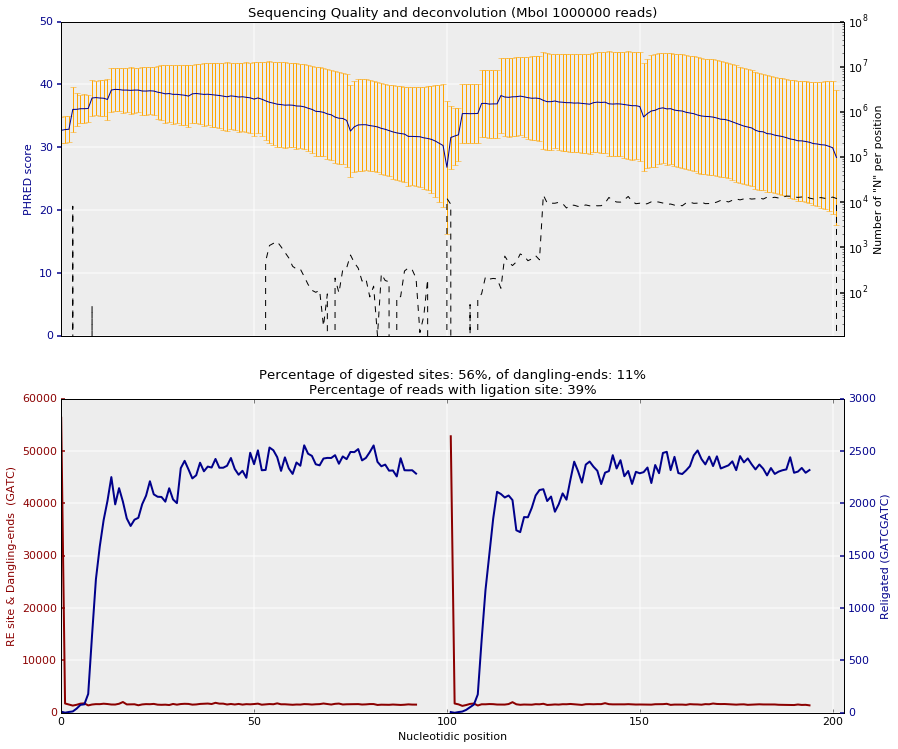

(10.9159, 38.5393)

In [25]:
from pytadbit.utils.fastq_utils import quality_plot

quality_plot('HiC003/SRR1658572.fastq', nreads=1000000, r_enz='MboI', paired=True)

The plot on the top represents the typical per nucleotide quality profile of NGS reads, with the addition of the proportion of "N" found at each position. This plot is done over the first milion reads, as this is usually enough to asses the general quality of the experiment.

The second plot, is specific to Hi-C experiments. Given a restriction enzyme the function searches for the presence of ligation sites and of undigested restriction enzyme sites. Depending on the enzyme used the function can differentiate between dangling-ends and undigested sites.

From this proportion some qulaity statistic can be inferred before the mapping:
 - The percentage of digested sites wich is the ratio of digested over undigested sites found over the reads analyzed
 - The percentage os dangling-ends which is the number of time a digested site is found at the begining of a read
 - The percentage of ligation sites which is the number of times a ligation site is found in the processed reads. This number has to be transfrom to reflect the reality as it corresponds only to the sequenced part of the DNA fragment. For example, in this case, if the mean fragment size is 400 nucleotides and we found that 11% of 1 million reads present 1 ligation site, we should expect a proportional number of ligation sites in the insert (unsequenced space between the ends of the reads). Thus, in this case we would have a final number 22% of the reads with at least one ligation site.
 
For the other replicates used in this tutorial, the enzymes (DpnII and HindIII) allow to differentiate between dangling-ends and undigested sites, as their cut site is inside the recognition pattern (*note that in the bellow plot we are now only seing one of the ends of the reads as we used the `--split-file` we have the one end per file*):

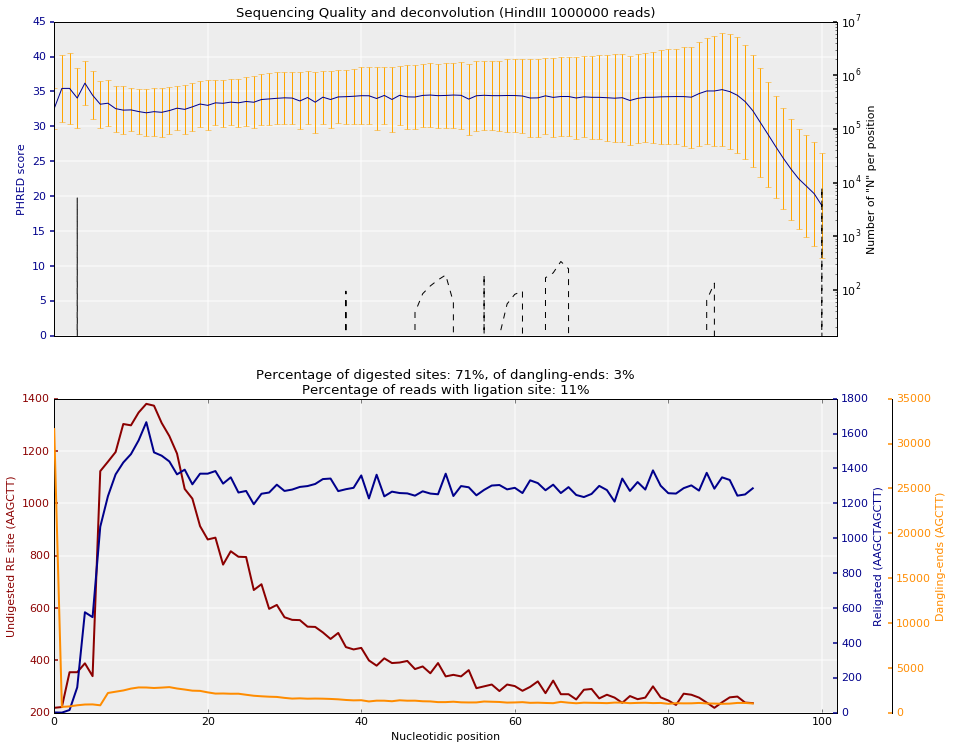

(3.1608, 11.3747)

In [26]:
quality_plot('HiC035/SRR1658625_1.fastq', nreads=1000000, r_enz='HindIII')

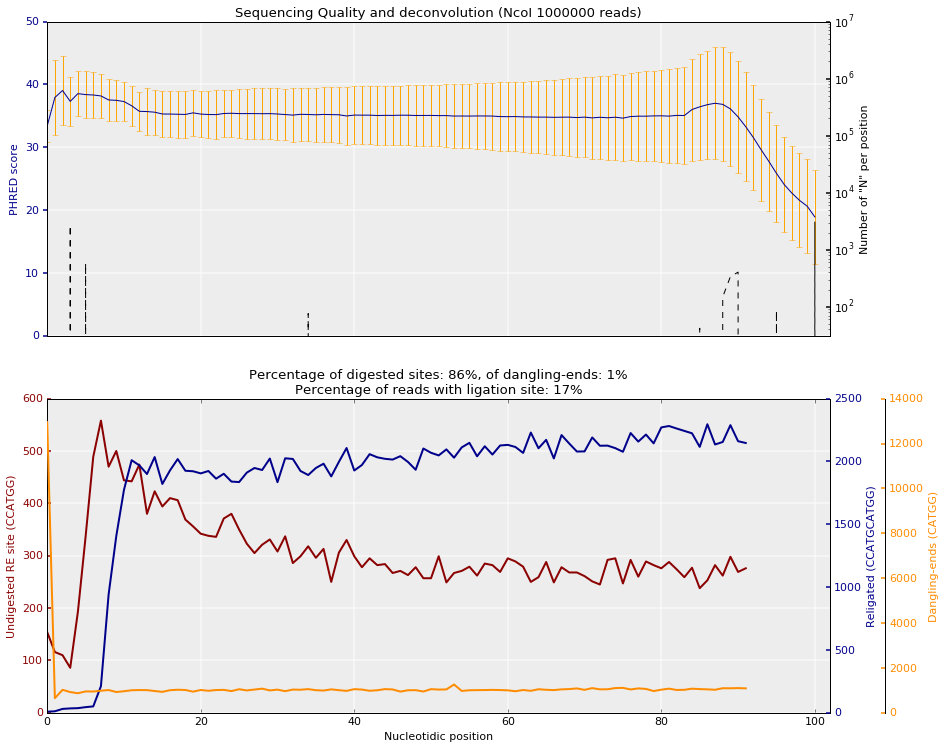

(1.2954, 17.1003)

In [27]:
quality_plot('HiC036/SRR1658632_1.fastq', nreads=1000000, r_enz='NcoI')

### Mapping

TADbit implements a flexible mapping that can be set to mimmic either the **iterative mapping** as proposed by [Imakaev2012]_ , or other mapping strategies based on the restriction enzyme fragments we call them **fragment-based mapping**.

In [1]:
import pytadbit

In [2]:
from pytadbit.mapping.mapper import full_mapping

#### Iterative mapping

The bellow example would be following the iterative mapping strategy, defining the windows over which to do the iterations:

In [4]:
print 'Mapping the first end of the read\n'
mapped_r1 = full_mapping('/scratch/db/Genomes/index_files/Homo_sapiens-79/Homo_sapiens.gem', 
                         '/scratch/test/rao2014/HiC003/SRR1658572.fastq',
                         '/scratch/test/rao2014/HiC003/01_it-mapped_read1', 
                         windows=((1,25), (1,50), (1,75),(1,100)),
                         frag_map=False, nthreads=8, clean=True, 
                         temp_dir='/scratch/test/rao2014/tmp_HiC003')

Mapping the first end of the read

Preparing FASTQ file
  - conversion to MAP format
  - trimming reads 1-25
Mapping reads in window 1-25...
TO GEM /scratch/test/rao2014/tmp_HiC003/SRR1658572_NbfVlq
/usr/local/bin/gem-mapper -I /scratch/db/Genomes/index_files/Homo_sapiens-79/Homo_sapiens.gem -q offset-33 -m 0.04 -s 0 --allow-incomplete-strata 0.00 --granularity 10000 --max-decoded-matches 1 --min-decoded-strata 0 --min-insert-size 0 --max-insert-size 0 --min-matched-bases 0.8 --gem-quality-threshold 26 --max-big-indel-length 15 --mismatch-alphabet ACGT -E 0.30 --max-extendable-matches 20 --max-extensions-per-match 1 -e 0.04 -T 8 -i /scratch/test/rao2014/tmp_HiC003/SRR1658572_NbfVlq -o /scratch/test/rao2014/tmp_HiC003/SRR1658572_NbfVlq_full_1-25
Parsing result...
   x removing GEM input /scratch/test/rao2014/tmp_HiC003/SRR1658572_NbfVlq
   x removing map /scratch/test/rao2014/tmp_HiC003/SRR1658572_NbfVlq_full_1-25.map
Preparing MAP file
  - trimming reads 1-50
   x removing original inp

In [5]:
print 'Mapping the first end of the read\n'
mapped_r2 = full_mapping('/scratch/db/Genomes/index_files/Homo_sapiens-79/Homo_sapiens.gem', 
                         '/scratch/test/rao2014/HiC003/SRR1658572.fastq',
                         '/scratch/test/rao2014/HiC003/01_it-mapped_read2',
                         windows=((101,125), (101,150), (101,175),(101,200)),
                         frag_map=False, nthreads=8, clean=True, 
                         temp_dir='/scratch/test/rao2014/tmp_HiC003')

Mapping the first end of the read

Preparing FASTQ file
  - conversion to MAP format
  - trimming reads 101-125
Mapping reads in window 101-125...
TO GEM /scratch/test/rao2014/tmp_HiC003/SRR1658572_L3K0wQ
/usr/local/bin/gem-mapper -I /scratch/db/Genomes/index_files/Homo_sapiens-79/Homo_sapiens.gem -q offset-33 -m 0.04 -s 0 --allow-incomplete-strata 0.00 --granularity 10000 --max-decoded-matches 1 --min-decoded-strata 0 --min-insert-size 0 --max-insert-size 0 --min-matched-bases 0.8 --gem-quality-threshold 26 --max-big-indel-length 15 --mismatch-alphabet ACGT -E 0.30 --max-extendable-matches 20 --max-extensions-per-match 1 -e 0.04 -T 8 -i /scratch/test/rao2014/tmp_HiC003/SRR1658572_L3K0wQ -o /scratch/test/rao2014/tmp_HiC003/SRR1658572_L3K0wQ_full_101-125
Parsing result...
   x removing GEM input /scratch/test/rao2014/tmp_HiC003/SRR1658572_L3K0wQ
   x removing map /scratch/test/rao2014/tmp_HiC003/SRR1658572_L3K0wQ_full_101-125.map
Preparing MAP file
  - trimming reads 101-150
   x removi

#### Fragment-based mapping

And here bellow an alternative mapping, fragment-based, in this case the restriction enzyme (RE) name is needed. And the windows parameter is only used for defining which part of read should be used.

In [9]:
print 'Mapping the first end of the read\n'
mapped_r1 = full_mapping('/scratch/db/Genomes/index_files/Homo_sapiens-79/Homo_sapiens.gem', 
                         '/scratch/test/rao2014/HiC003/SRR1658572.fastq',
                         '/scratch/test/rao2014/HiC003/01_mapped_read1',
                         windows=(1,100),
                         r_enz='MboI', frag_map=True, nthreads=8, clean=True, temp_dir='tmp')

Mapping the first end of the read

Preparing FASTQ file
  - conversion to MAP format
  - trimming reads 1-100
Mapping reads in window 1-100...
TO GEM /home/fransua/Box/tadbits/tadbit/doc/notebooks/tmp/SRR1658572_eQYIHW
/usr/local/bin/gem-mapper -I /scratch/db/Genomes/index_files/Homo_sapiens-79/Homo_sapiens.gem -q offset-33 -m 0.04 -s 0 --allow-incomplete-strata 0.00 --granularity 10000 --max-decoded-matches 1 --min-decoded-strata 0 --min-insert-size 0 --max-insert-size 0 --min-matched-bases 0.8 --gem-quality-threshold 26 --max-big-indel-length 15 --mismatch-alphabet ACGT -E 0.30 --max-extendable-matches 20 --max-extensions-per-match 1 -e 0.04 -T 8 -i /home/fransua/Box/tadbits/tadbit/doc/notebooks/tmp/SRR1658572_eQYIHW -o /home/fransua/Box/tadbits/tadbit/doc/notebooks/tmp/SRR1658572_eQYIHW_full_1-100
Parsing result...
   x removing GEM input /home/fransua/Box/tadbits/tadbit/doc/notebooks/tmp/SRR1658572_eQYIHW
   x removing map /home/fransua/Box/tadbits/tadbit/doc/notebooks/tmp/SRR16585

In [10]:
print '\n\nMapping the second end of the read\n'
mapped_r2 = full_mapping('/scratch/db/Genomes/index_files/Homo_sapiens-79/Homo_sapiens.gem', 
                         '/scratch/test/rao2014/HiC003/SRR1658572.fastq',
                         '/scratch/test/rao2014/HiC003/01_mapped_read2',
                         windows=(101,200),
                         r_enz='MboI', frag_map=True, nthreads=8, clean=True, temp_dir='tmp')



Mapping the second end of the read

Preparing FASTQ file
  - conversion to MAP format
  - trimming reads 101-200
Mapping reads in window 101-200...
TO GEM /home/fransua/Box/tadbits/tadbit/doc/notebooks/tmp/SRR1658572_3OpPDr
/usr/local/bin/gem-mapper -I /scratch/db/Genomes/index_files/Homo_sapiens-79/Homo_sapiens.gem -q offset-33 -m 0.04 -s 0 --allow-incomplete-strata 0.00 --granularity 10000 --max-decoded-matches 1 --min-decoded-strata 0 --min-insert-size 0 --max-insert-size 0 --min-matched-bases 0.8 --gem-quality-threshold 26 --max-big-indel-length 15 --mismatch-alphabet ACGT -E 0.30 --max-extendable-matches 20 --max-extensions-per-match 1 -e 0.04 -T 8 -i /home/fransua/Box/tadbits/tadbit/doc/notebooks/tmp/SRR1658572_3OpPDr -o /home/fransua/Box/tadbits/tadbit/doc/notebooks/tmp/SRR1658572_3OpPDr_full_101-200
Parsing result...
   x removing GEM input /home/fransua/Box/tadbits/tadbit/doc/notebooks/tmp/SRR1658572_3OpPDr
   x removing map /home/fransua/Box/tadbits/tadbit/doc/notebooks/tmp

The Fragment based mapping works in 2 steps:
 - First read ends are aligned entirely, assuming that no ligation occured in them.
 - Second, for the read ends that were not mapped, the function searches for a ligation site (in the case of MboI this would correspond to `GATCGATC` and in the case of HindIII to `AAGCTAGCTT`). The read-end is splitted accordingly replacing the ligation site by two RE sites:

    read-end-part-one---AAGCTAGCTT----read-end-part-two
    
will be splitted in:

    read-end-part-one---AAGCTT 

and

    AAGCTT----read-end-part-two

### Map parsing

In case we lost the lists of paths we can "reload" them like this:

In [31]:
import os

mapped_r1 = []
mapped_r2 = []

r1_dir = '/scratch/test/rao2014/HiC003/01_mapped_read1'
r2_dir = '/scratch/test/rao2014/HiC003/01_mapped_read2'

for mapped in os.listdir(r1_dir):
    mapped_r1.append(os.path.join(r1_dir, mapped))
for mapped in os.listdir(r2_dir):
    mapped_r2.append(os.path.join(r2_dir, mapped))

print 'Output files of the maping of the first end of the reads:\n - ' + '\n - '.join(mapped_r1)
print 'Output files of the maping of the second end of the reads:\n - ' + '\n - '.join(mapped_r2)


Output files of the maping of the first end of the reads:
 - /scratch/test/rao2014/HiC003/01_mapped_read1/SRR1658572_frag_1-100.map
 - /scratch/test/rao2014/HiC003/01_mapped_read1/SRR1658572_full_1-100.map
Output files of the maping of the second end of the reads:
 - /scratch/test/rao2014/HiC003/01_mapped_read2/SRR1658572_frag_101-200.map
 - /scratch/test/rao2014/HiC003/01_mapped_read2/SRR1658572_full_101-200.map


We collect mapped reads at all window sizes into a single file (a single file for read1, and a single file for read2). These 2 files also contain the placement of the restriction enzyme sites in the genome.

In [12]:
from pytadbit.parsers.map_parser    import parse_map
from pytadbit.parsers.genome_parser import parse_fasta

In [21]:
# loads the genome
genome_seq = parse_fasta('/scratch/db/Genomes/genomes/Homo_sapiens-79/Homo_sapiens.fa')

Parsing 1
Parsing 2
Parsing 3
Parsing 4
Parsing 5
Parsing 6
Parsing 7
Parsing 8
Parsing 9
Parsing 10
Parsing 11
Parsing 12
Parsing 13
Parsing 14
Parsing 15
Parsing 16
Parsing 17
Parsing 18
Parsing 19
Parsing 20
Parsing 21
Parsing 22
Parsing X
Parsing Y
Parsing MT


In [14]:
from pytadbit.utils.file_handling import mkdir

mkdir('/scratch/test/rao2014/HiC003/02_parsed_reads/')

In [15]:
# new file with info of each "read1" and its placement with respect to RE sites
reads1 = '/scratch/test/rao2014/HiC003/02_parsed_reads/read1.tsv'
# new file with info of each "read2" and its placement with respect to RE sites
reads2 = '/scratch/test/rao2014/HiC003/02_parsed_reads/read2.tsv'

In [32]:
print 'Parse MAP files...'
parse_map(mapped_r1, mapped_r2, out_file1=reads1, out_file2=reads2, genome_seq=genome_seq, 
          re_name='MboI', verbose=True, ncpus=8)

Parse MAP files...
Searching and mapping RE sites to the reference genome
Found 7191117 RE sites
Loading read1
loading file: /scratch/test/rao2014/HiC003/01_mapped_read1/SRR1658572_frag_1-100.map
loading file: /scratch/test/rao2014/HiC003/01_mapped_read1/SRR1658572_full_1-100.map
Merge sort.....................................................
Getting Multiple contacts
Loading read2
loading file: /scratch/test/rao2014/HiC003/01_mapped_read2/SRR1658572_frag_101-200.map
loading file: /scratch/test/rao2014/HiC003/01_mapped_read2/SRR1658572_full_101-200.map
Merge sort...................................................
Getting Multiple contacts


({0: {1: 14363191, 2: 38080970}, 1: {1: 13755441, 2: 37571439}},
 {0: 5361490, 1: 4879802})

The output files generated here are BED-like files, with a header with the size of the chromosomes used, followed by the list of reads mapped.

The column for each read are:

  - Read Id
  - Chromosome name
  - genomic position
  - strand (1: positive strand, 0: negative strand)
  - mapped read length (this length can be extended when the fragment is found to be spanning over the insert paired-end read)
  - upstream RE site position
  - downstream RE site position

### Mapping analysis

#### Plot mapping efficiency

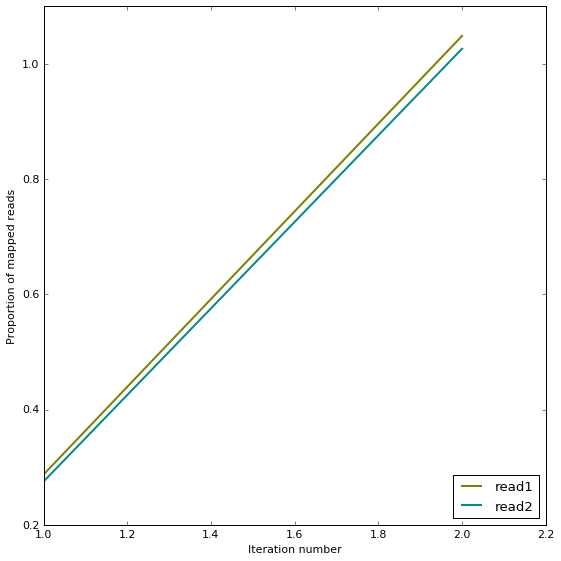

In [33]:
from pytadbit.mapping.analyze import plot_iterative_mapping

lengths = plot_iterative_mapping(reads1, reads2, total_reads=50000000)

### Merging mapped "read1" and "read2"

We create a new file that will contain only the reads mapped in both ends ("read1" and "read2" uniquely mapped)

In [37]:
from pytadbit.mapping import get_intersection

In [1]:
reads  = '/scratch/test/rao2014/HiC003/02_parsed_reads/both_map.tsv'

In [39]:
get_intersection(reads1, reads2, reads, verbose=True)

Getting intersection of reads 1 and reads 2:
 
  .......... .......... .......... .......... ........
Found 44674766 pair of reads mapping uniquely
Sorting easch temporary file by genomic coordinate
    1025/1025 sorted files
Removing temporary files...


(44674766, {2: 7044121, 3: 20910, 4: 51})

#### Descriptive statistics

In order to confirm the size of the inserts fed to the sequencer, we can look at the distribution of genomic distances between the mapped read1 and read2 of dangling-ends. From this analysis we can extract the maximum insert size, that is an important value to classify reads during the filtering process.

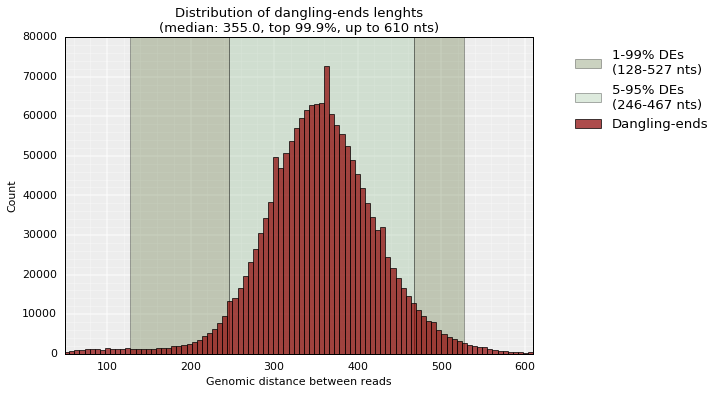

[355.0, 610.0]

In [2]:
from pytadbit.mapping.analyze import insert_sizes

insert_sizes(reads, show=True)

### Simple descriptive stats

#### How the count in interaction falls as the genomic distance is larger

Here we want to see how the interaction between to two genomic region decays as the distance between these two loci is larger. Theexpectation is that at distances between 700 kb and 10 Mb the decay in logarithm scale is -1.

In the example below are represented the interactions in between genomic regions that, each, spans over 10 kb (resolution parameter).

((-1.0699233238000596, 15.456024589131042, -0.9992506172369725),
 (-1.1471902596970704, 15.335536453854143, -0.99565698091932198),
 (-2.4979074477418139, 23.753684595554244, -0.92419616437542085))

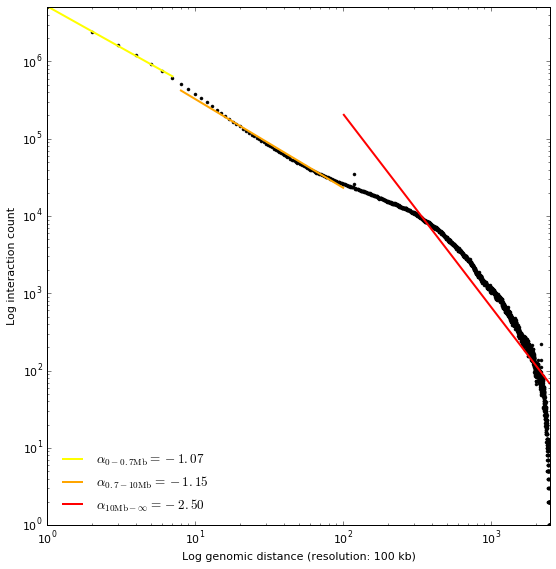

In [3]:
from pytadbit.mapping.analyze import plot_distance_vs_interactions

plot_distance_vs_interactions(reads, max_diff=10000, resolution=100000)

#### Genomic coverage of our reads

In the plot above we want to see the distribution of the reads mapped in the genome (regardless of their interactions). Here, te expecation is to see a minimum number of reads mapping in all positions of the genome with falls around centromeres and telomeres. 

In [2]:
from pytadbit.mapping.analyze import plot_genomic_distribution

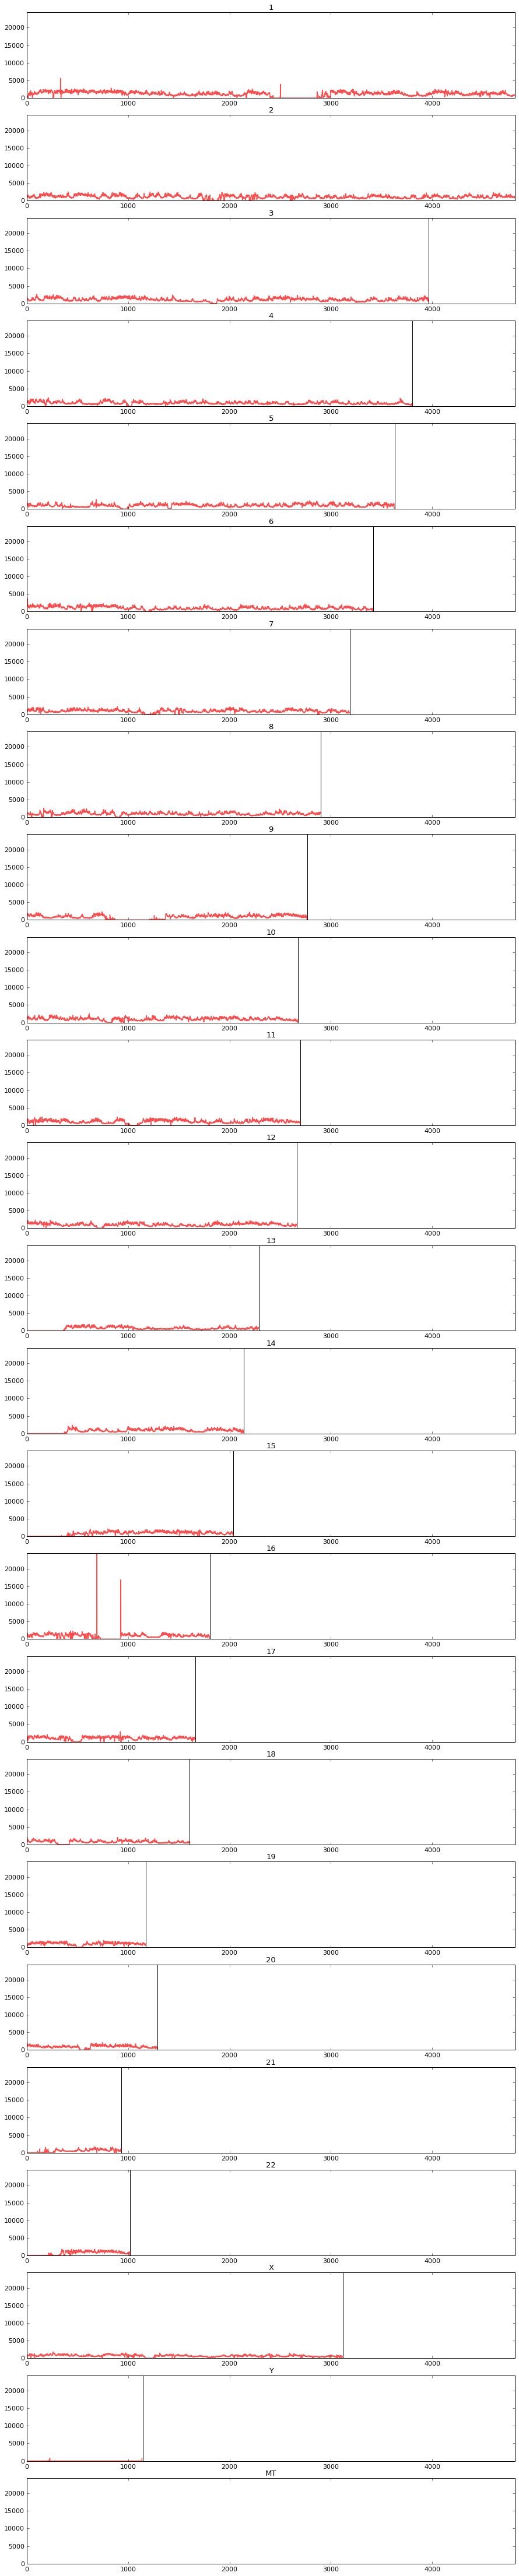

In [3]:
plot_genomic_distribution(reads, resolution=50000, first_read=True)

*The picks in the plot correspond to PCR artifact that we will remove in the filtering step (see bellow)*

This plot can be zoomed in the y axis in order to avoid depending on these artifacts. The plot can also be generated only for a given number of chromosomes

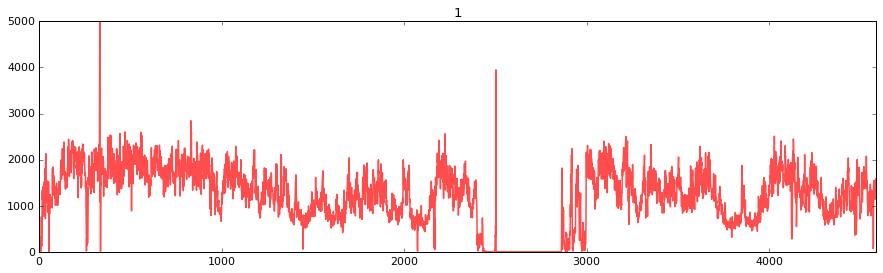

In [12]:
plot_genomic_distribution(reads, resolution=50000, first_read=True, ylim=(0, 5000), 
                          chr_names=['1'], nreads=1000000)

#### Interaction matrix

The plot above is probablythe most informative, in order to infer the qualtity of an Hi-C experiment. This plot represents the matrix of interaction, the distribution of these interaction as an histogram or as a function of genomic distance. Some statistics on the specificity of these interaction, like the cis-to-trans ratio (expected to be at least between 40 and 60%), and the 3 first eigen vectors of the matrix highlighting the principal structural features of the matrix (in non-normalized matrices eigen-vectors are not very informative however).

In [17]:
from pytadbit.mapping.analyze import hic_map

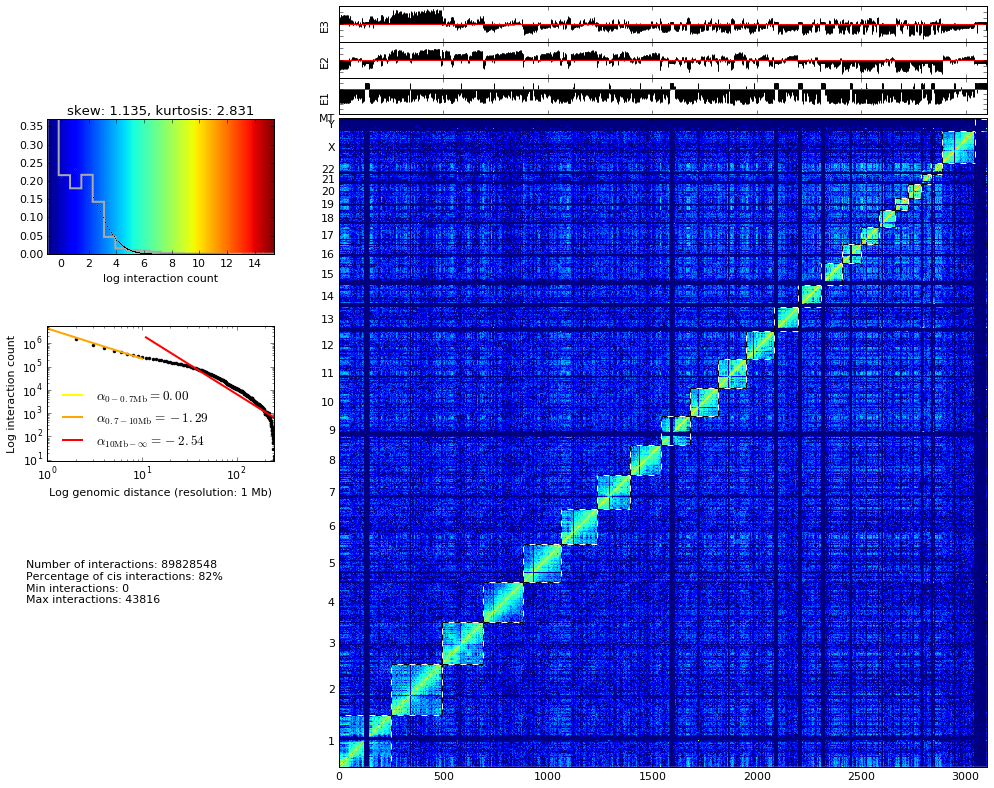

In [8]:
hic_map(reads, resolution=1000000, show=True)

## Filter reads

In order to remove interactions between reads that are experimental artifacts, or just uninoformative, a series of adjustable filters can be applied:

1. self-circle : reads are comming from a single RE fragment and point to the outside (—-<===—===>—)
2. dangling-end : reads are comming from a single RE fragment and point to the inside (—-===>—<===—)
3. error : reads are comming from a single RE fragment and point in the same direction
4. extra dangling-end : reads are comming from different RE fragment but are close enough (< max_molecule length) and point to the inside. Maximum molecule length parameter can be set at 1.5 or 2 times the 99.9 percentile returned by insert_size function above.
5. too close from RES : semi-dangling-end filter, start position of one of the read is too close (5 bp by default) from RE cutting site (with 4 base-pair-cutter enzyme it can be set to 4nt). This filter is in general not taken into account in *in situ* Hi-C experiments, and with 4bp cutters as the ligation may happen only one side of the DNA fragments.
6. too short : remove reads comming from small restriction less than 100 bp (default) because they are comparable to the read length, and are thus probably artifacts.
7. too large : remove reads comming from large restriction fragments (default: 100 Kb, P < 10-5 to occur in a randomized genome) as they likely represent poorly assembled or repeated regions
8. over-represented : reads coming from the top 0.5% most frequently detected restriction fragments, they may be prone to PCR artifacts or represent fragile regions of the genome or genome assembly errors
9. duplicated : the combination of the start positions (and direction) of the reads is repeated -> PCR artifact (only keep one copy)
10. random breaks : start position of one of the read is too far (more than min_dist_to_re) from RE cutting site. Non-canonical enzyme activity or random physical breakage of the chromatin. The min_dist_to_re parameter can be set as the 99.9 percentile of the distribution of insert sizes, as this parameter is important it is recommended to try different combinations and observe how it may affect the quality of the resulting interaction matrix



The function `filter_reads` works in parallel (4 threads), and creates one file per filter (10 files, which path are an extension of the input file containing the reads).

In [6]:
from pytadbit.mapping.filter import filter_reads

masked = filter_reads(reads, max_molecule_length=610, min_dist_to_re=915,
                      over_represented=0.005, max_frag_size=100000,
                      min_frag_size=100, re_proximity=4)

Filtered reads (and percentage of total):

     Mapped both                :     58868016 (100.00%)
  -----------------------------------------------------
   1- self-circle               :        19763 (  0.03%)
   2- dangling-end              :      1617270 (  2.75%)
   3- error                     :         7907 (  0.01%)
   4- extra dangling-end        :     11123319 ( 18.90%)
   5- too close from RES        :     15365731 ( 26.10%)
   6- too short                 :      6742667 ( 11.45%)
   7- too large                 :          917 (  0.00%)
   8- over-represented          :      2111005 (  3.59%)
   9- duplicated                :       274430 (  0.47%)
  10- random breaks             :        36700 (  0.06%)


Previous function creates one file per filter. Each containing the list of IDs of the reads falling into the corresponding filter.
In order to apply filter, the function `apply_filter` will create a new file without the reads contained in the files. By default all filters are applied.

In [9]:
from pytadbit.mapping.filter import apply_filter
filt_reads  = '/scratch/test/rao2014/HiC003/filtered_map.tsv'

In [8]:
apply_filter(reads, filt_reads, masked)

    saving to file 33541378 reads without .


33541378

As mentioned, it is usually a good idea not to consider the filter number 5: "too close form REs". To do so, we can just use the `filters` parameter as (the less conservative approach would be to use only the filters 1, 2, 3, 9 and 10):

In [9]:
apply_filter(reads, filt_reads, masked, filters=[1,2,3,4,6,7,8,9,10])

    saving to file 40026192 reads without .


40026192

Filters can also be applied in a "reverse" way in order to select only "bad" reads.

In [5]:
sc_de  = '/scratch/test/rao2014/HiC003/self_circles_and_dangling-ends.tsv'

In [10]:
apply_filter(reads, sc_de, masked, filters=[1,2], reverse=True)

    saving to file 1637033 reads with .


1637033

This can be used for example to analyze the distribution of dangling-ends and self-circle along the genome

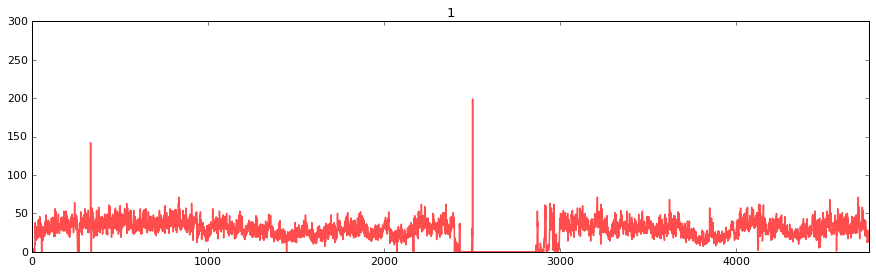

In [6]:
plot_genomic_distribution(sc_de, resolution=50000, first_read=True, chr_names=['1'], ylim=(0,300))

Once filtered the peaks previously seen should disapeear:

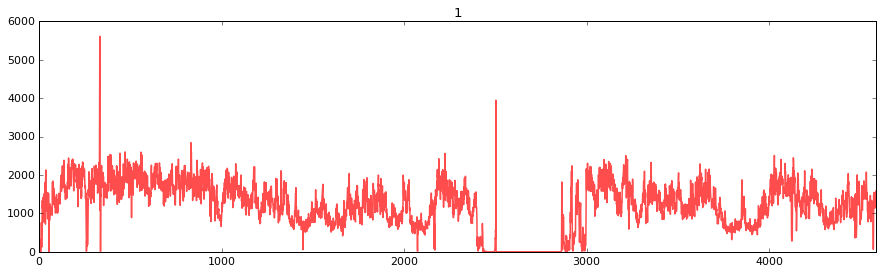

In [15]:
plot_genomic_distribution(reads, resolution=50000, first_read=True, chr_names=['1'],
                          nreads=1000000, ylim=(0,6000))

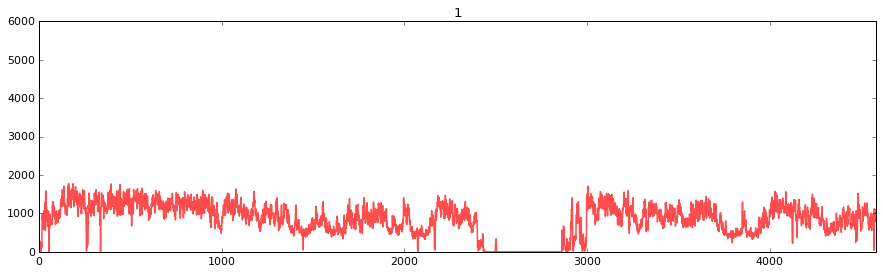

In [16]:
plot_genomic_distribution(filt_reads, resolution=50000, first_read=True, chr_names=['1'],
                          nreads=1000000, ylim=(0,6000))

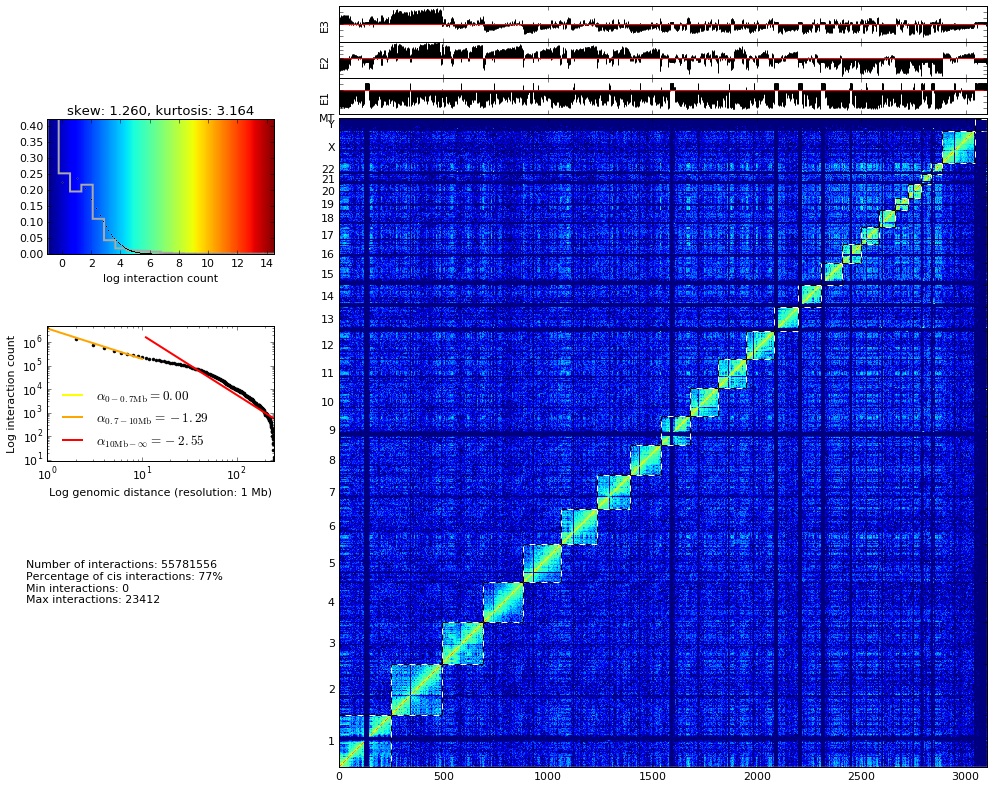

In [18]:
hic_map(filt_reads, resolution=1000000, show=True)

These maps can be zoomed to a given region, like first chromosome:

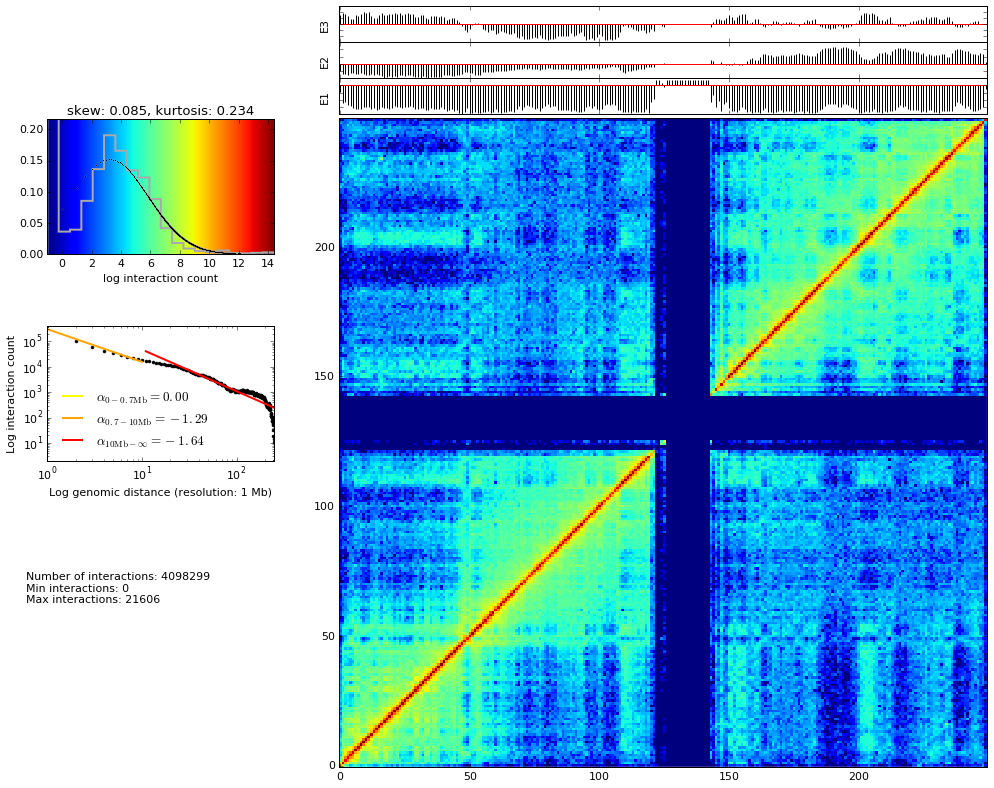

In [19]:
hic_map(filt_reads, resolution=1000000, show=True, focus=(1, 250))

Same as above, calling the focus using directly chromosome name and using a smaller resolution (100 kb):

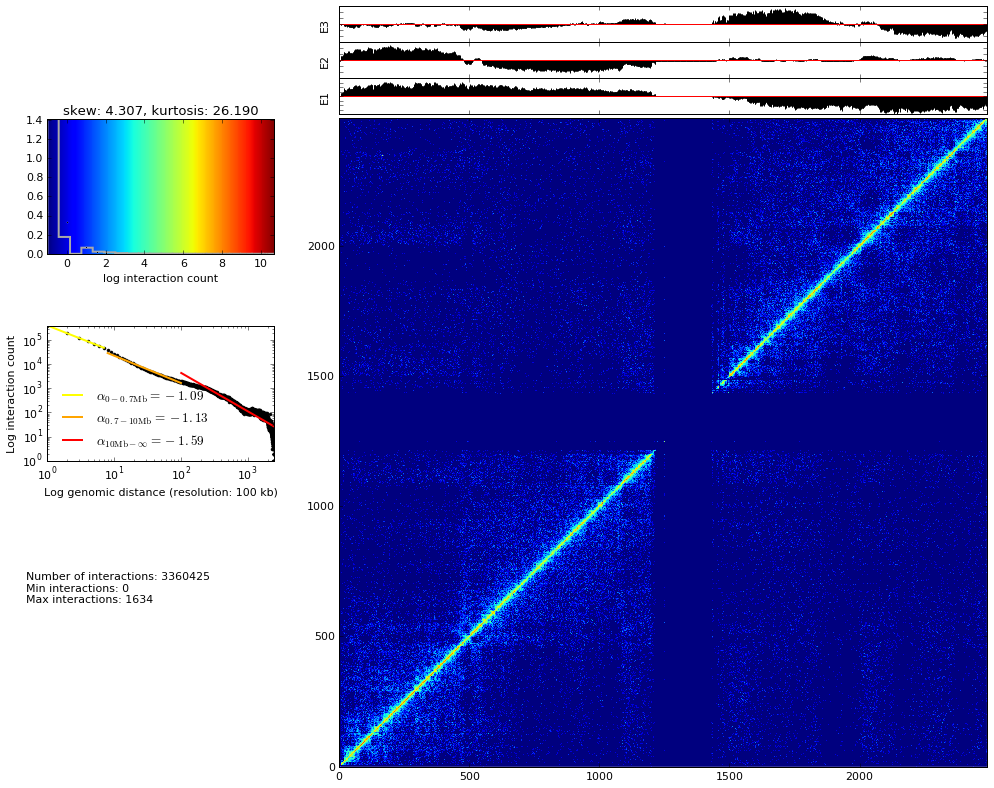

In [20]:
hic_map(filt_reads, resolution=100000, show=True, focus='1')

## Filtering and normalization

### Removal of columns having to few data

Depending on the normalization method, the presence of columns with high proportion of zeros can prevent to converge into a satisfactory result.

For this part of the processing of the data we will start to work on full matrices. This step is critical in the sense that **we have to decide at which resolution we are going to analyze the data**. For this tutorial we will use a resolution of 1 Mb.

*Note* : as all previous steps ended in the generation of a single file, we just need to load the name of the saved file with the filtered reads:

In [23]:
filt_reads  = '/scratch/test/rao2014/HiC003/filtered_map.tsv'

In [24]:
from pytadbit import load_hic_data_from_reads

hic_data = load_hic_data_from_reads(filt_reads, resolution=1000000)

We can visualize the matrix using the same function as before, with the file of reads: 

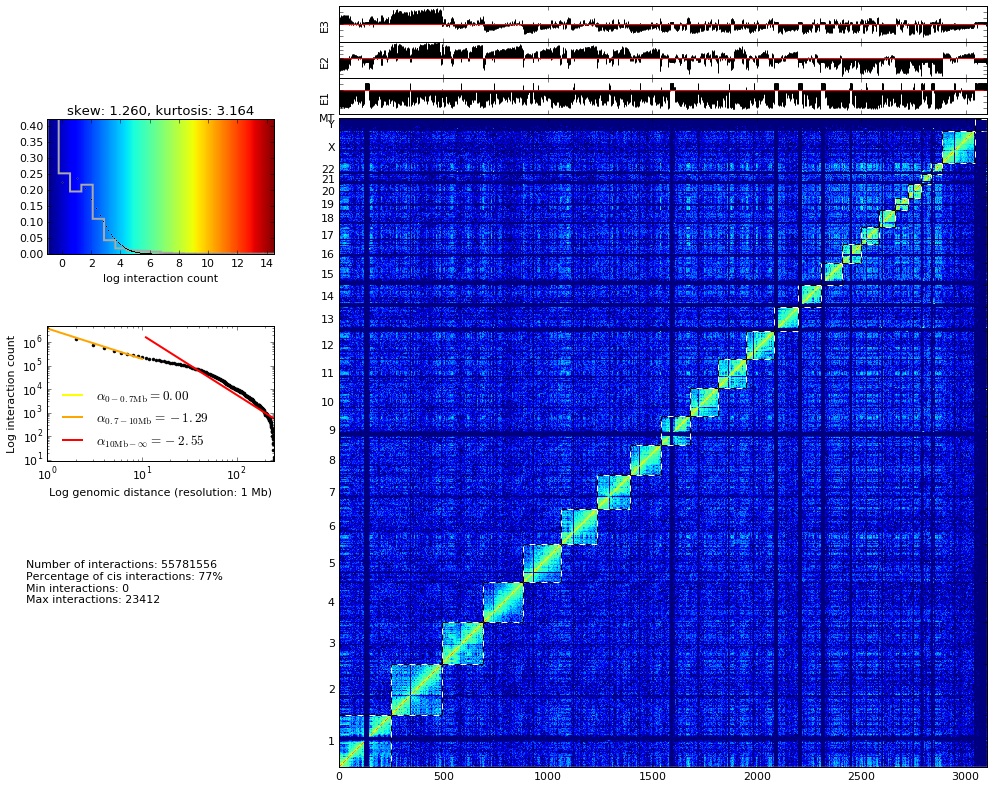

In [25]:
from pytadbit.mapping.analyze import hic_map

hic_map(hic_data, show=True)


   123   124   125   126   127   128   129   130   131   132   133   134   135   136   137   138   139   140   141   142
   143   342   343   584   585   742   882   929   930   931   932   953  1124  1294  1295  1296  1297  1440  1441  1541
  1585  1586  1587  1588  1589  1590  1591  1592  1593  1594  1595  1596  1597  1598  1599  1600  1601  1602  1720  1721
  1722  1866  1867  1868  1950  1986  1987  2085  2086  2087  2088  2089  2090  2091  2092  2093  2094  2095  2096  2097
  2098  2099  2100  2101  2102  2200  2201  2202  2203  2204  2205  2206  2207  2208  2209  2210  2211  2212  2213  2214
  2215  2216  2217  2218  2307  2308  2309  2310  2311  2312  2313  2314  2315  2316  2317  2318  2319  2320  2321  2322
  2323  2324  2325  2326  2327  2446  2447  2448  2449  2450  2451  2452  2453  2454  2455  2524  2525  2526  2601  2602
  2603  2604  2605  2691  2692  2752  2790  2791  2792  2793  2794  2795  2796  2797  2801  2802  2837  2838  2839  2840
  2841  2842  2843  2844  2845 

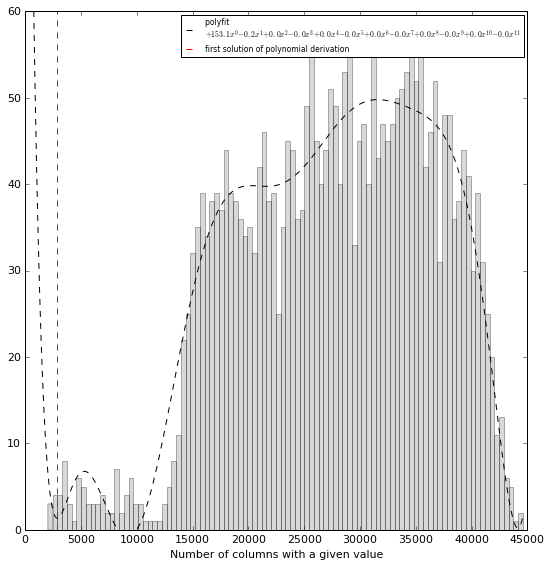

Found 237 of 3103 columnswith poor signal


/home/fransua/.miniconda2/lib/python2.7/site-packages/pytadbit/utils/hic_filtering.py:149: ComplexWarning: Casting complex values to real discards the imaginary part
  round(root, 3), ' '.join(

   123   124   125   126   127   128   129   130   131   132   133   134   135   136   137   138   139   140   141   142
   143   145   342   343   584   585   742   882   929   930   931   932   953  1124  1294  1295  1296  1297  1440  1441
  1541  1585  1586  1587  1588  1589  1590  1591  1592  1593  1594  1595  1596  1597  1598  1599  1600  1601  1602  1603
  1608  1609  1720  1721  1722  1866  1867  1868  1950  1986  1987  2085  2086  2087  2088  2089  2090  2091  2092  2093
  2094  2095  2096  2097  2098  2099  2100  2101  2102  2200  2201  2202  2203  2204  2205  2206  2207  2208  2209  2210
  2211  2212  2213  2214  2215  2216  2217  2218  2307  2308  2309  2310  2311  2312  2313  2314  2315  2316  2317  2318
  2319  2320  2321  2322  2323  2324  2325  2326  2327  2329  2446  2447  2448 

In [26]:
hic_data.filter_columns(draw_hist=True)

Filtered columns (to high count of zeroes, or to low mean value) will be skipped in most of analysis available and are now shaded in the matrix representation:

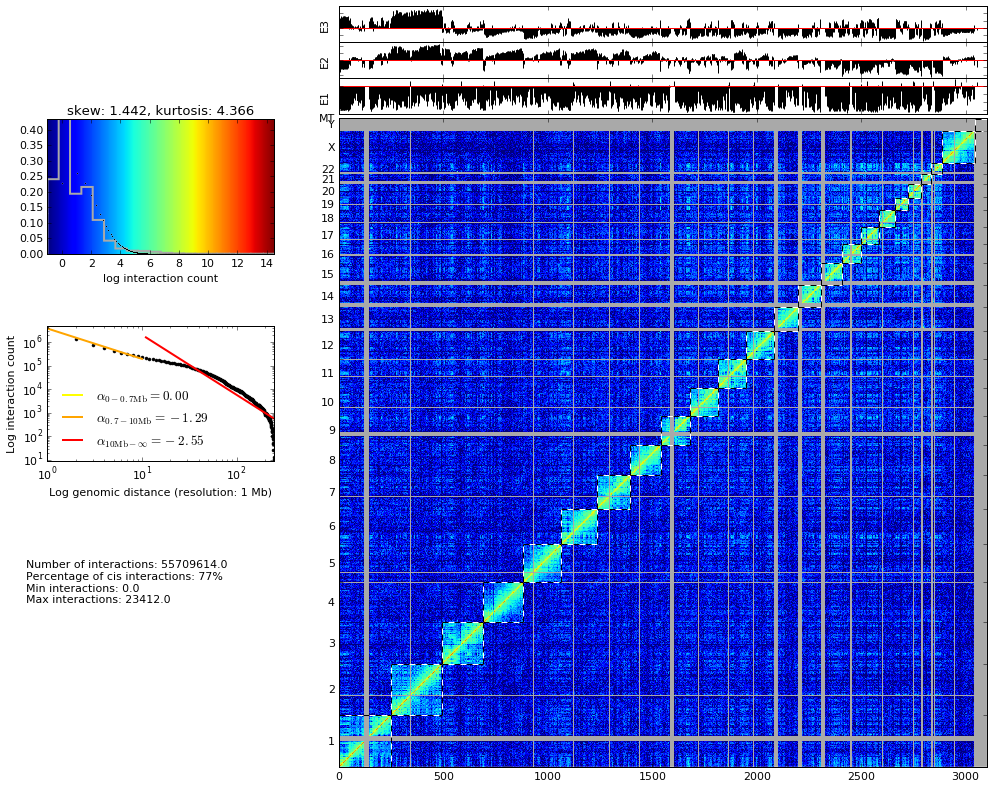

In [27]:
hic_map(hic_data, show=True)

### Normalization

TADbit implements ICE normalization strategy [Imakaev2012]_ which basically consists constructing a new in dividing each cell

In [28]:
hic_data.normalize_hic(iterations=9, max_dev=0.1)

iterative correction
  - copying matrix
  - computing baises
          2836.000       27884.987       44592.000    0   0.89830
         20089.022       30027.383       85246.499    1   1.83896
         15842.132       31075.219       40561.598    2   0.49020
         25400.491       31543.690       47025.449    3   0.49080
         24496.468       31783.468       37210.830    4   0.22927
         28213.858       31908.415       37511.228    5   0.17559
         28468.121       31976.815       35032.068    6   0.10973
         29843.664       32015.253       34841.364    7   0.08827
rescaling to factor 1


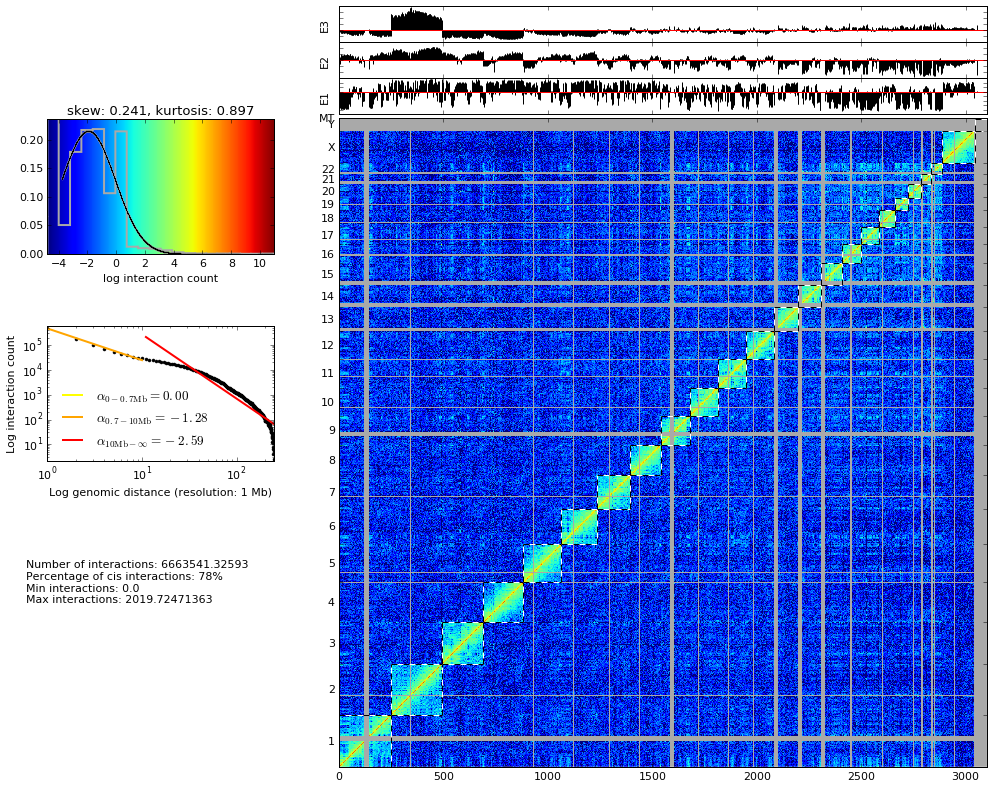

In [29]:
hic_map(hic_data, show=True, normalized=True)